<a href="https://colab.research.google.com/github/zilmara-rodrigues/amns-aulas/blob/main/amns_05_clustering_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Métricas de Avaliação para Algoritmos de Clustering

Neste notebook, exploraremos diversas métricas utilizadas para avaliar a qualidade dos resultados de algoritmos de clustering. Como o clustering é uma tarefa de aprendizado não supervisionado, a avaliação de seus resultados é um desafio, pois geralmente não dispomos de rótulos verdadeiros (*ground truth*). Portanto, focaremos em métricas internas, que avaliam a qualidade da estrutura dos clusters baseando-se apenas nos dados e na partição gerada.

## Conteúdos Abordados

1.  **Geração de Datasets Sintéticos**: Criação de conjuntos de dados com diferentes estruturas geométricas para testar os algoritmos.
2.  **Aplicação de Algoritmos de Clustering**: Utilização dos algoritmos K-Means, Hierárquico Aglomerativo e DBSCAN nos datasets.
3.  **Métricas de Avaliação Interna**:
    * Introdução teórica e matemática de cada métrica.
    * Implementação manual das funções para cálculo.
    * **Silhouette Score**
    * **Davies-Bouldin Index (DBI)**
    * **Dunn Index**
4.  **Análise Comparativa**: Avaliação e comparação dos resultados dos algoritmos em cada dataset utilizando as métricas implementadas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist, pdist, squareform
import pandas as pd

# Configurações para reprodutibilidade e visualização
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# 1. Geração de Datasets Sintéticos

Para avaliar a eficácia dos algoritmos e das métricas, utilizaremos datasets sintéticos com características distintas. Isso nos permite visualizar e entender intuitivamente como cada algoritmo se comporta em diferentes topologias de dados.

* **Blobs**: Clusters esféricos e bem separados, um cenário ideal para algoritmos baseados em centroides como o K-Means.
* **Circles**: Clusters concêntricos, um desafio para algoritmos que assumem convexidade.
* **Moons**: Clusters não convexos e com formas complexas.

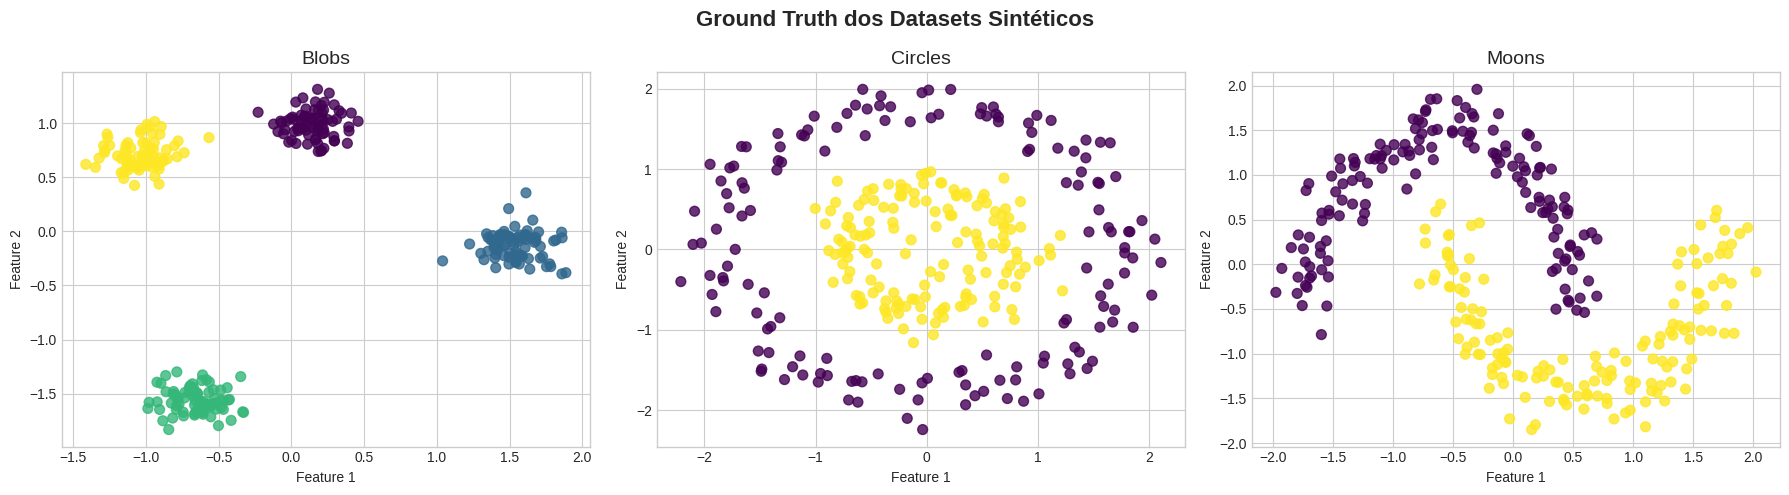

In [2]:
# Geração dos datasets
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)
X_circles, y_circles = make_circles(n_samples=300, noise=0.1, factor=0.4, random_state=42)
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Normalização dos dados para que os algoritmos baseados em distância funcionem corretamente
X_blobs = StandardScaler().fit_transform(X_blobs)
X_circles = StandardScaler().fit_transform(X_circles)
X_moons = StandardScaler().fit_transform(X_moons)

# Dicionário para armazenar os datasets
datasets = {
    'Blobs': (X_blobs, y_blobs),
    'Circles': (X_circles, y_circles),
    'Moons': (X_moons, y_moons)
}

# Visualização dos datasets originais (ground truth)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Ground Truth dos Datasets Sintéticos', fontsize=16, fontweight='bold')

for i, (name, (X, y)) in enumerate(datasets.items()):
    axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.8)
    axes[i].set_title(name, fontsize=14)
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

# 2. Aplicação de Algoritmos de Clustering

Agora, aplicaremos três algoritmos de clustering populares a cada um dos datasets gerados. Os parâmetros de cada algoritmo foram ajustados para corresponder ao número esperado de clusters ou às características dos dados.

* **K-Means**: Define `n_clusters`.
* **Hierárquico Aglomerativo**: Define `n_clusters`.
* **DBSCAN**: Define `eps` (distância máxima entre dois pontos para serem considerados vizinhos) e `min_samples` (número mínimo de pontos para formar uma região densa).

In [3]:
# Configuração dos algoritmos
kmeans_params = {'n_clusters': 0, 'random_state': 42}
agglomerative_params = {'n_clusters': 0}
dbscan_params = {'eps': 0.3, 'min_samples': 4}

# Dicionário para armazenar os resultados
clustering_results = {}

for name, (X, y) in datasets.items():
    n_clusters = len(np.unique(y))
    kmeans_params['n_clusters'] = n_clusters
    agglomerative_params['n_clusters'] = n_clusters

    # K-Means
    kmeans = KMeans(**kmeans_params)
    kmeans_labels = kmeans.fit_predict(X)

    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(**agglomerative_params)
    agglomerative_labels = agglomerative.fit_predict(X)

    # DBSCAN
    dbscan = DBSCAN(**dbscan_params)
    dbscan_labels = dbscan.fit_predict(X)

    clustering_results[name] = {
        'K-Means': kmeans_labels,
        'Agglomerative': agglomerative_labels,
        'DBSCAN': dbscan_labels,
    }

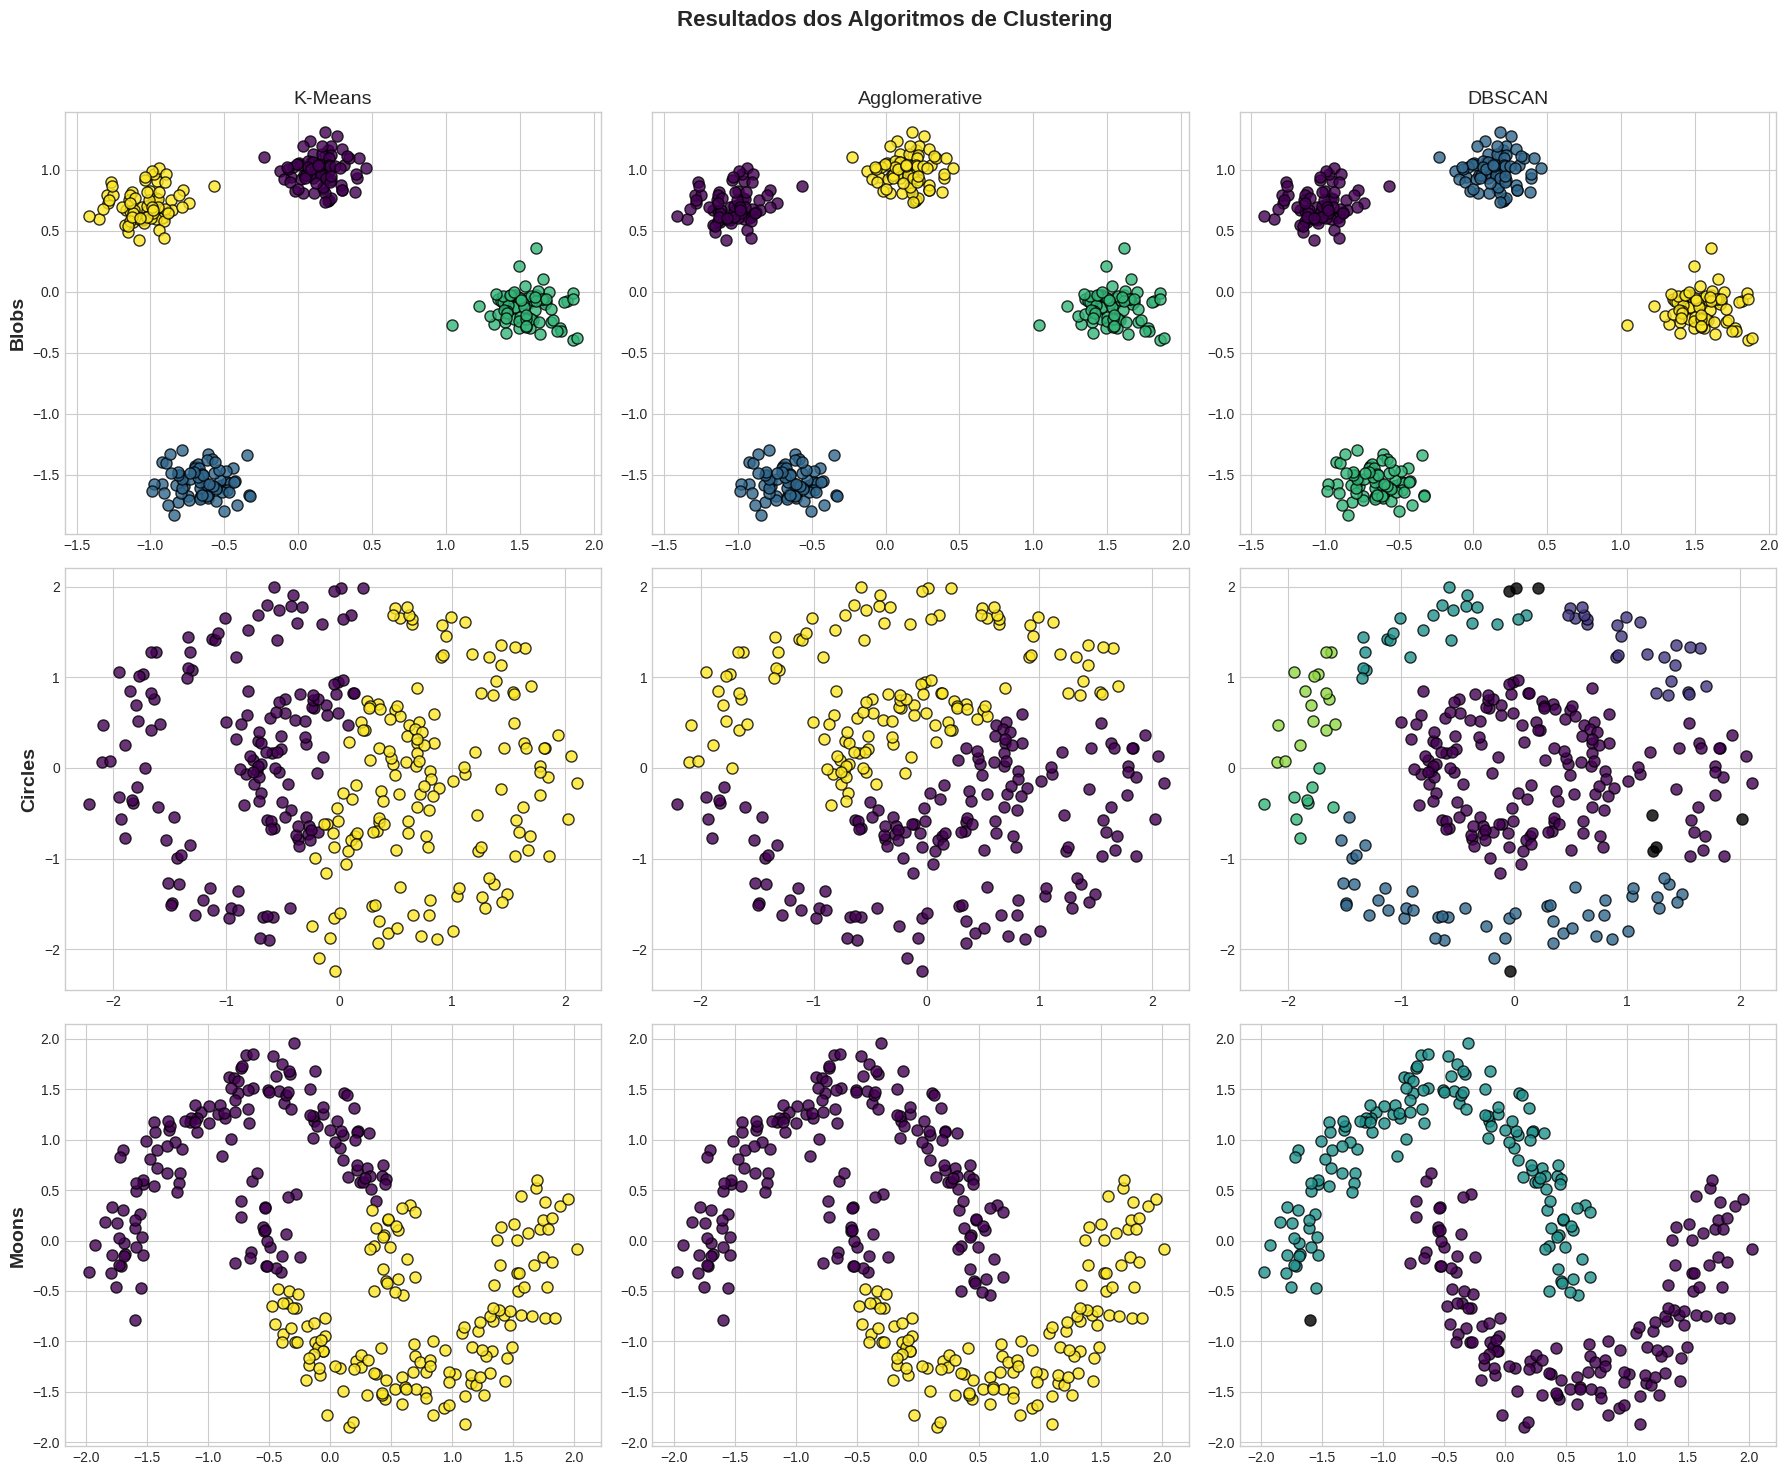

In [4]:
# Visualização dos resultados
fig, axes = plt.subplots(len(datasets), 3, figsize=(18, 15))
fig.suptitle('Resultados dos Algoritmos de Clustering', fontsize=16, fontweight='bold')

for i, (dataset_name, results) in enumerate(clustering_results.items()):
    X, _ = datasets[dataset_name]
    for j, (algo_name, labels) in enumerate(results.items()):
        ax = axes[i, j]
        # Pontos de ruído (-1) em preto para DBSCAN
        unique_labels = set(labels)
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

        for k, col in zip(unique_labels, colors):
            if k == -1:
                col = [0, 0, 0, 1]  # Preto para ruído

            class_member_mask = (labels == k)
            xy = X[class_member_mask]
            ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                    markeredgecolor='k', markersize=8, alpha=0.8)

        if i == 0:
            ax.set_title(algo_name, fontsize=14)
        if j == 0:
            ax.set_ylabel(dataset_name, fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. Métricas de Avaliação Interna

Nesta seção, detalharemos e implementaremos as métricas internas para avaliar a qualidade dos clusters sem usar os rótulos verdadeiros.

## Silhouette Score

O Silhouette Score mede quão similar um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). A pontuação varia de -1 a +1, onde um valor alto indica que o objeto está bem combinado ao seu próprio cluster e mal combinado aos clusters vizinhos.

### Formulação Matemática

Para um único ponto de dados $i$, o score de silhueta $s(i)$ é calculado como:

$$ s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}} $$

Onde:
- $a(i)$ é a distância média de $i$ para todos os outros pontos no mesmo cluster (coesão intra-cluster).
$$ a(i) = \frac{1}{|C_k| - 1} \sum_{j \in C_k, i \neq j} d(i, j) $$
em que $i \in C_k$.
- $b(i)$ é a menor distância média de $i$ para todos os pontos em qualquer outro cluster, do qual $i$ não é membro (separação inter-cluster).
$$ b(i) = \min_{m \neq k} \left( \frac{1}{|C_m|} \sum_{j \in C_m} d(i, j) \right) $$

O Silhouette Score para todo o dataset é a média de $s(i)$ sobre todos os pontos.

In [5]:
def silhouette_score(X, labels):
    """
    Calcula o Silhouette Score para um conjunto de dados e seus rótulos de cluster.
    """
    n_samples = len(X)

    # Calcula a matriz de distâncias par a par
    distances = cdist(X, X)

    silhouette_vals = []
    for i in range(n_samples):
        # Coesão (a_i)
        cluster_i_mask = (labels == labels[i])
        cluster_i_mask[i] = False # Exclui o próprio ponto

        if np.sum(cluster_i_mask) == 0:
            a_i = 0 # Se o ponto é o único no cluster
        else:
            a_i = np.mean(distances[i][cluster_i_mask])

        # Separação (b_i)
        b_i = np.inf
        for label_k in np.unique(labels):
            if label_k != labels[i]:
                cluster_k_mask = (labels == label_k)
                mean_dist_k = np.mean(distances[i][cluster_k_mask])
                if mean_dist_k < b_i:
                    b_i = mean_dist_k

        # Score de silhueta para o ponto i
        s_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_vals.append(s_i)

    return np.mean(silhouette_vals)

## Davies-Bouldin Index (DBI)

O Davies-Bouldin Index é definido como a similaridade média de cada cluster com seu cluster mais similar. A similaridade é uma medida que compara a distância intra-cluster com a distância inter-cluster. Valores mais baixos do DBI indicam um melhor clustering.

### Formulação Matemática

O índice é calculado como:

$$ DBI = \frac{1}{K} \sum_{k=1}^{K} \max_{m \neq k} \left( R_{km} \right) $$

Onde $K$ é o número de clusters e $R_{km}$ é a medida de similaridade entre o cluster $C_k$ e o cluster $C_m$:

$$ R_{km} = \frac{S_k + S_m}{D_{km}} $$

- $S_k$ é a dispersão média intra-cluster (distância média de cada ponto ao centroide do cluster $C_k$).
$$ S_k = \left( \frac{1}{|C_k|} \sum_{x \in C_k} \|x - \mu_k\|^2 \right)^{1/2} $$
em que $\mu_k$ é o centroide de $C_k$.
- $D_{km}$ é a distância entre os centroides dos clusters $C_k$ e $C_m$.
$$ D_{km} = \|\mu_k - \mu_m\|_2 $$

In [6]:
def davies_bouldin_score(X, labels):
    """
    Calcula o Davies-Bouldin Index para um conjunto de dados e seus rótulos.
    """
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]  # remove outliers

    # Calcula centroides e dispersões de cada cluster
    centroids = np.array([X[labels == i].mean(axis=0) for i in unique_labels])
    dispersions = np.array([
        np.mean(cdist(X[labels == i], [centroids[idx]]))
        for idx, i in enumerate(unique_labels)
    ])

    # Calcula a máxima similaridade entre clusters
    db_index = 0
    for i in range(n_clusters):
        max_similarity = -np.inf
        for j in range(n_clusters):
            if i != j:
                dist_centroids = np.linalg.norm(centroids[i] - centroids[j])
                similarity = (dispersions[i] + dispersions[j]) / dist_centroids
                max_similarity = max(max_similarity, similarity)
        db_index += max_similarity

    return db_index / n_clusters

## Dunn Index

O Dunn Index visa identificar clusters que são compactos e bem separados. Ele é definido como a razão entre a mínima distância inter-cluster e a máxima distância intra-cluster. Um valor mais alto do Dunn Index significa um melhor clustering.

### Formulação Matemática

O índice é dado por:

$$ D = \frac{\min_{1 \le k < m \le K} d(C_k, C_m)}{\max_{1 \le l \le K} \text{diam}(C_l)} $$

Onde:
- $d(C_k, C_m)$ é a distância entre os clusters $C_k$ e $C_m$ (distância inter-cluster), que pode ser definida de várias formas (e.g., distância entre centroides). Usaremos a distância mínima entre quaisquer dois pontos de clusters diferentes.
$$ d(C_k, C_m) = \min_{x \in C_k, y \in C_m} \|x - y\|_2 $$
- $\text{diam}(C_l)$ é o diâmetro do cluster $C_l$ (distância intra-cluster máxima), definido como a maior distância entre quaisquer dois pontos no mesmo cluster.
$$ \text{diam}(C_l) = \max_{x, y \in C_l} \|x - y\|_2 $$

In [7]:
def dunn_index(X, labels):
    """
    Calcula o Dunn Index para um conjunto de dados e seus rótulos.
    """
    unique_labels = np.unique(labels)
    pairwise_dists = squareform(pdist(X))

    # Máxima distância intra-cluster
    max_intra = 0
    for lab in unique_labels:
        idx = np.where(labels == lab)[0]
        if len(idx) > 1:
            d = np.max(pairwise_dists[np.ix_(idx, idx)])
            if d > max_intra:
                max_intra = d

    if max_intra == 0:
        return np.inf

    # Mínima distância inter-cluster
    min_inter = np.inf
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            idx_i = np.where(labels == unique_labels[i])[0]
            idx_j = np.where(labels == unique_labels[j])[0]
            d = np.min(pairwise_dists[np.ix_(idx_i, idx_j)])
            if d < min_inter:
                min_inter = d

    return min_inter / max_intra

# 4. Análise Comparativa

Finalmente, vamos calcular cada métrica para cada combinação de dataset e algoritmo para avaliar e comparar os resultados.

* **Silhouette Score**: Quanto maior, melhor.
* **Davies-Bouldin Index**: Quanto menor, melhor.
* **Dunn Index**: Quanto maior, melhor.

In [8]:
evaluation_results = []

for dataset_name, results in clustering_results.items():
    X, _ = datasets[dataset_name]
    for algo_name, labels in results.items():
        silhouette = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        dunn = dunn_index(X, labels)

        evaluation_results.append({
            'Dataset': dataset_name,
            'Algorithm': algo_name,
            'Silhouette Score': silhouette,
            'Davies-Bouldin Index': dbi,
            'Dunn Index': dunn
        })

In [9]:
# Criar DataFrame para visualização
results_df = pd.DataFrame(evaluation_results)

# Dicionário de formatação apenas para colunas numéricas
formatter = {
    'Silhouette Score': '{:.3f}',
    'Davies-Bouldin Index': '{:.3f}',
    'Dunn Index': '{:.3f}'
}

# Aplicar o estilo e a formatação seletiva
results_df_styled = results_df.style.background_gradient(
    cmap='viridis', subset=['Silhouette Score', 'Dunn Index']
).background_gradient(
    cmap='viridis_r', subset=['Davies-Bouldin Index']
).format(formatter)

display(results_df_styled)

,Dataset,Algorithm,Silhouette Score,Davies-Bouldin Index,Dunn Index
0,Blobs,K-Means,0.839,0.126,0.466
1,Blobs,Agglomerative,0.839,0.150,0.466
2,Blobs,DBSCAN,0.839,0.278,0.466
3,Circles,K-Means,0.316,1.245,0.027
4,Circles,Agglomerative,0.311,1.255,0.031
5,Circles,DBSCAN,0.192,0.832,0.042
6,Moons,K-Means,0.491,0.806,0.030
7,Moons,Agglomerative,0.448,0.866,0.058
8,Moons,DBSCAN,0.245,1.024,0.107
